# Feature Extractor Code 

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

2025-03-26 10:43:17.178378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 10:43:17.189898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742996597.203728 1971195 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742996597.207271 1971195 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 10:43:17.222404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from mae_code import *

In [3]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4


# PRETRAINING
EPOCHS = 100


## Load data


In [4]:
import os
import tensorflow as tf



base_dir = '../png_512'

# Create a dataset from images in the directory
dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir),              # Base directory
    labels='inferred',                   # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,                     # No labels
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,               # Batch size
    shuffle=False,                       # Do not shuffle the data
    interpolation='bilinear'
)




Found 70684 files.


I0000 00:00:1742996600.409822 1971195 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13655 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:55:00.0, compute capability: 8.6


## Functions

These functions are identical to those used in the pre-training code.


In [5]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
#             layers.RandomFlip("horizontal"),
#             layers.RandomRotation(factor=0.15),  # Rotação aleatória entre -30 e 30 graus (fator = 0.15 para 15 graus)
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0),
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

W0000 00:00:1742996600.738056 1971385 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


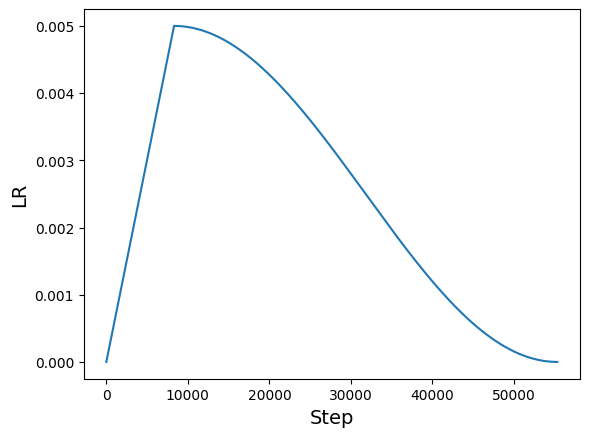

In [6]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(dataset)) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


## Load Weights from Pre-trained Models

In [7]:
# instantiate the models

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

optimizer = tf.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

#Compile and pretrain the model.
model.compile( optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"])

In [8]:
check_point = "pre-trained-models/mp75/"

# Creating the checkpoint to restore
checkpoint = tf.train.Checkpoint(
    patch_encoder=model.patch_encoder,
    encoder=model.encoder,
    decoder=model.decoder
)

# Define the directory where the checkpoint was saved
checkpoint_directory = check_point + 'mae_model/'

# Check if the checkpoint exists and restore it
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_directory)

if latest_checkpoint:
    checkpoint.restore(latest_checkpoint).expect_partial()
    print("Checkpoint restored successfully!")
else:
    print("No checkpoint found.")

Checkpoint restored successfully!


## Visualizing the Reconstruction

In [13]:
images = next(iter(dataset))

augmented_images = test_augmentation_model(images)

In [14]:

import matplotlib.pyplot as plt

def visualize_results(model, augmented_images):

    # Patch the augmented images.
    patches = model.patch_layer(augmented_images)

    # Encode the patches.
    (
        unmasked_embeddings,
        masked_embeddings,
        unmasked_positions,
        mask_indices,
        unmask_indices,
    ) = model.patch_encoder(patches)

    # Pass the unmasked patches to the encoder.
    encoder_outputs = model.encoder(unmasked_embeddings)

    # Create the decoder inputs.
    encoder_outputs = encoder_outputs + unmasked_positions
    decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
    decoder_outputs = model.decoder(decoder_inputs)

    # Show a masked patch image.
    masked_patches = model.patch_encoder.generate_masked_images(
        patches[2:6], unmask_indices[2:6], color = 0.3
)

    masked_images = []
    for masked_patch in masked_patches:
        # Apply the reconstruction function to the masked patch
        masked_image = model.patch_layer.reconstruct_from_patch(masked_patch)
        masked_images.append(masked_image)

    original_image = augmented_images[2:6]
    reconstructed_image = decoder_outputs[2:6]

    # Minimalistic plot settings
    fig, ax = plt.subplots(4, 3, figsize=(7.5, 10))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    for i in range(4):
        # Original
        ax[i, 0].imshow(original_image[i], cmap='gray')
        ax[i, 0].axis('off')

        # Masked
        ax[i, 1].imshow(masked_images[i], cmap='gray')
        ax[i, 1].axis('off')

        # Reconstruída
        ax[i, 2].imshow(reconstructed_image[i], cmap='gray')
        ax[i, 2].axis('off')

        if i == 0:
          ax[i, 0].set_title("Original")
          ax[i, 1].set_title("Masked")
          ax[i, 2].set_title("Reconstructed")

    plt.show()

In [15]:

# augmented_images = test_augmentation_model(images)
visualize_results(model, augmented_images)

2025-03-26 10:46:18.689341: W tensorflow/core/framework/op_kernel.cc:1829] UNKNOWN: JIT compilation failed.


UnknownError: Exception encountered when calling LayerNormalization.call().

[1m{{function_node __wrapped__Rsqrt_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Rsqrt] name: [0m

Arguments received by LayerNormalization.call():
  • inputs=tf.Tensor(shape=(128, 16, 16), dtype=float32)

## Extracting Latent Variables

In [16]:
import tensorflow as tf
from tqdm import tqdm

# Assuming you have a train_dataset containing multiple images

# Initialize an empty list to store the results for each image
processed_images = []

# Use tqdm to create a progress bar for the loop
for images in tqdm(dataset, total=len(dataset)):
    # Perform the same operations as in your code snippet

    # Apply augmentation to the image
    augmented_images = test_augmentation_model(images)

    # Patch the augmented images
    patches = patch_layer(augmented_images)

    # Encode the patches
    (
        unmasked_embeddings,
        masked_embeddings,
        unmasked_positions,
        mask_indices,
        unmask_indices,
    ) = model.patch_encoder(patches)

    # Pass the unmasked patches to the encoder
    encoder_outputs = model.encoder(unmasked_embeddings)

    # Append the processed image to the list
    processed_images.append(encoder_outputs)

# processed_images now contains the processed data for the entire dataset, and you will see a progress bar as the loop iterates.


  0%|          | 0/553 [00:00<?, ?it/s]2025-03-26 10:46:33.432266: W tensorflow/core/framework/op_kernel.cc:1829] UNKNOWN: JIT compilation failed.
2025-03-26 10:46:33.432314: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: UNKNOWN: JIT compilation failed.
  0%|          | 0/553 [00:00<?, ?it/s]


UnknownError: Exception encountered when calling LayerNormalization.call().

[1m{{function_node __wrapped__Rsqrt_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Rsqrt] name: [0m

Arguments received by LayerNormalization.call():
  • inputs=tf.Tensor(shape=(128, 16, 16), dtype=float32)

## Reshaping and Creating a DF

In [35]:
# number of patches not masked
num_embb = int((1- MASK_PROPORTION) * NUM_PATCHES)


# Initialize a new list to store the reshaped tensors
reshaped_outputs = []

# Use tqdm to create a progress bar for the loop
for output in tqdm(processed_images, total=len(processed_images), desc="Reshaping"):
    reshaped_tensor = tf.reshape(output, [output.shape[0], num_embb  * 16])
    reshaped_outputs.append(reshaped_tensor)

Reshaping: 100%|██████████| 553/553 [00:00<00:00, 24392.93it/s]


In [36]:


# Assuming reshaped_outputs is a list of shape (553, 128, num_embb  * 16)s)

# Convert the list to a NumPy array
reshaped_array = np.array(reshaped_outputs[:-1])

# Reshape the array to have shape (553*128, num_embb  * 16))
reshaped_array = reshaped_array.reshape(-1, num_embb  * 16)

# Create a DataFrame from the reshaped array
df = pd.DataFrame(reshaped_array)



In [39]:
# Assuming reshaped_outputs is a list of arrays and df is your DataFrame
last_batch = reshaped_outputs[-1]  # Assuming the last element is the last batch
last_batch = last_batch[:28]  # Keep only the first 28 elements
last_batch = np.array(last_batch)

# Append the last batch to the DataFrame
df = pd.concat([df, pd.DataFrame(last_batch.reshape(-1, num_embb * 16))], ignore_index=True)

In [ ]:
# Add the filenames that correspond to observations in the DataFrame

all_files = [filename for filename in os.listdir('png_512') if filename.endswith('.png')]


# Remove "resultado_" prefix and ".png" suffix from all elements in the list
cleaned_list = [filename.replace('resultado_', '').replace('.png', '') for filename in all_files]


cleaned_list = sorted(cleaned_list)

df['Filenames'] = cleaned_list

70684

In [44]:
df

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,Filenames
0,2.713018,0.248438,-0.886864,0.268349,1.508462,1.807836,0.505072,1.642043,-0.250945,-0.063316,...,2.236362,-0.029565,-0.425447,-1.235220,0.073183,-1.092381,-1.373107,-2.343335,-0.905959,calf_id_1387_20210621_743_depth_0042
1,2.624924,0.629111,-0.591922,-0.192780,0.812261,1.430371,0.191832,1.938710,-0.061651,-2.085104,...,1.494807,0.298769,-1.716003,-1.043834,0.007887,0.532930,-1.364805,-2.301051,-0.816526,calf_id_1387_20210621_743_depth_0057
2,4.232648,0.415663,0.075946,-0.526574,0.361823,1.068625,0.428031,0.469490,-0.058819,-1.810384,...,0.271095,-0.083337,-1.232917,-1.391044,0.441832,0.000605,-1.255802,-1.356733,-1.606273,calf_id_1387_20210621_743_depth_0059
3,3.514310,0.802001,-0.575343,-0.739115,0.868305,1.702362,-0.043106,1.775961,0.421748,-0.404240,...,1.828842,0.442927,-0.395177,-1.869071,-0.836037,-0.784057,-0.952475,-1.296218,-1.243929,calf_id_1387_20210621_743_depth_0061
4,2.332275,-1.888337,-1.713106,-0.089379,0.163423,1.234081,-0.182431,2.740392,-0.544144,0.413912,...,1.529484,-0.093163,-1.136749,-0.989103,0.888478,-0.350512,-1.369802,-2.166603,-1.022001,calf_id_1387_20210621_743_depth_0064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70679,3.032672,1.409726,0.013584,-0.555183,-0.597251,-0.211954,0.347795,-1.265983,0.217782,-1.816682,...,0.049214,1.046716,-0.525688,-0.758744,-0.925704,-0.021923,-1.056197,3.232506,2.351360,calf_id_1599_20220207_408_depth_0353
70680,3.540733,0.676284,-0.287784,-0.115948,-1.490668,0.028791,0.141225,-1.308898,0.328296,-2.144178,...,-1.361377,0.308411,-2.167634,-0.741325,-0.776100,0.543800,-1.118199,1.359208,2.216729,calf_id_1599_20220207_408_depth_0361
70681,0.762354,0.004851,0.728426,0.622469,-1.461071,-0.720045,0.107302,-1.650131,-0.310118,-1.669446,...,-1.405831,-0.047660,-1.869463,-1.606760,-0.560286,1.300325,0.247568,2.553275,2.450906,calf_id_1599_20220207_408_depth_0383
70682,1.671676,1.159225,-0.789472,0.739988,-1.599553,-0.525311,-0.415925,-1.030062,0.202364,-1.413841,...,-0.976835,-0.230113,-1.530534,-1.438978,-0.881212,0.944735,0.678627,2.865215,2.822381,calf_id_1599_20220207_408_depth_0390
